# Lecture 6: Model Performance Evaluation

Welcome to this hands-on tutorial on **model performance evaluation**! While the theoretical foundations of evaluation metrics are covered in the lectures, this notebook focuses on practical implementations and critical insights for validating your models effectively.

In this module, we’ll explore techniques for evaluating the performance of both classification and segmentation models. However, the broader goal is to encourage a **critical** approach to model validation, applicable across a variety of tasks. A robust evaluation framework ensures that your model's predictions are not only accurate but also reliable and generalizable.

By the end of this notebook, you’ll understand how to:

1) Implement key metrics for classification tasks, such as accuracy, precision, recall, and F1-score.
2) Evaluate segmentation models using metrics like Intersection over Union (IoU) and Dice Coefficient.
3) Identify and avoid common pitfalls in model evaluation to ensure unbiased and meaningful results.

For deeper insights, we recommend exploring these resources:

- [Metrics reloaded: recommendations for image analysis validation](https://www.nature.com/articles/s41592-023-02151-z)
- [Understanding metric-related pitfalls in image analysis validation](https://www.nature.com/articles/s41592-023-02150-0)

Let’s dive in and build a solid foundation for evaluating your models effectively!

# Classification

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import \
    train_test_split, \
    cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.metrics import \
    confusion_matrix, \
    precision_score, \
    recall_score, \
    f1_score, \
    roc_curve, \
    RocCurveDisplay, \
    roc_auc_score
%matplotlib inline

In this section of the notebook, we'll leverage the MNIST dataset. This dataset comprises handwritten digits ranging from 0 to 9, which our model will classify. We'll swiftly train a model and start our evaluation!

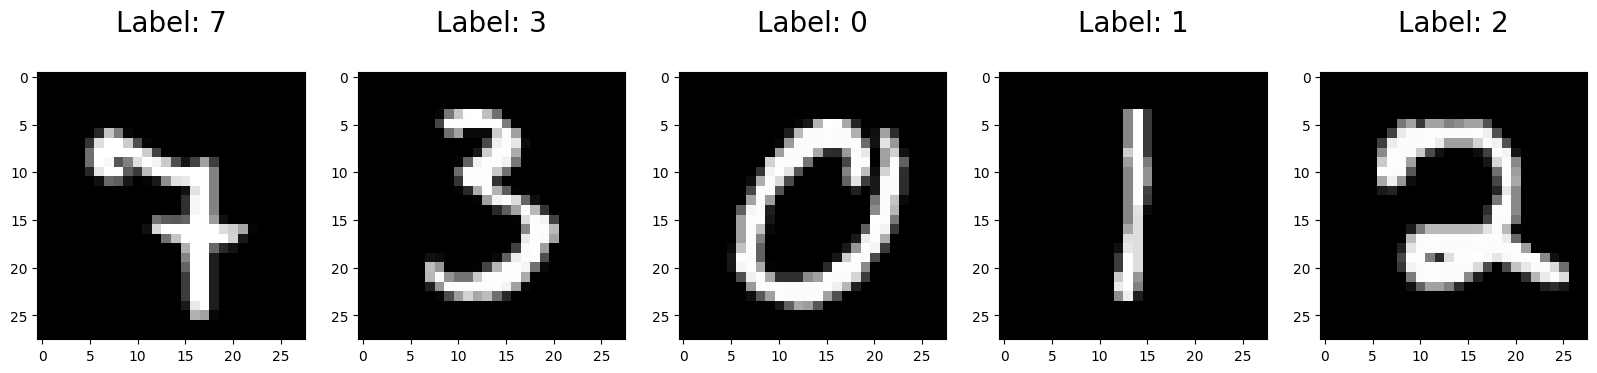

In [4]:
mnist = fetch_openml('mnist_784', data_home="./data", as_frame=False)

X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=1./7., random_state=0)

plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(X_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % int(label), fontsize = 20)

In [2]:
model = LogisticRegression()

In [3]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
print('accuracy = ', score)

NameError: name 'X_train' is not defined

Great, our model has been trained, and it's yielding a high accuracy. However, accuracy alone doesn't provide the complete picture. Can you determine which classes are the easiest or the most challenging for our model? It's not evident solely from accuracy. Let's delve deeper into performance evaluation to gain a more comprehensive understanding.

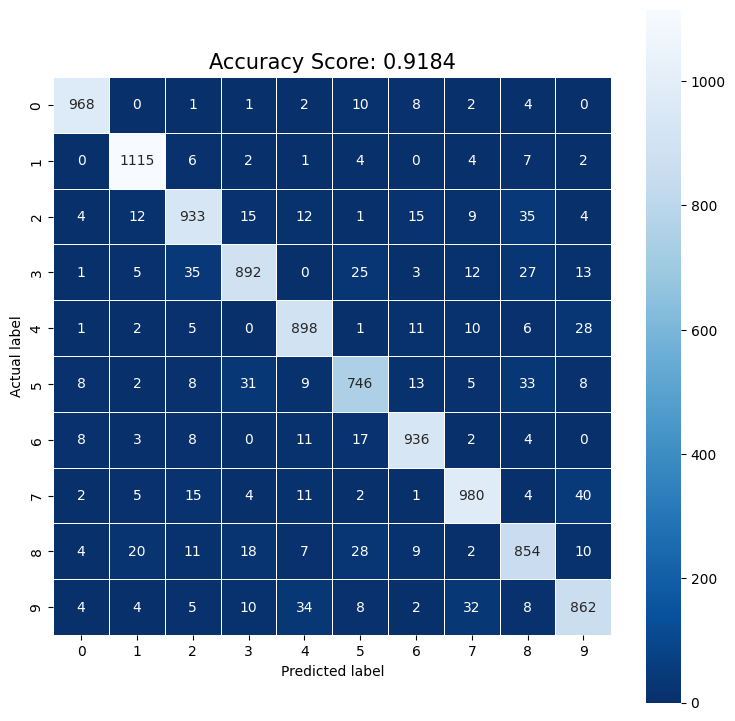

In [7]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

**Q.1** Can you identify the classes that are challenging to predict? Additionally, could you provide insights into why you think these particular classes are likely the most difficult for our model to classify accurately?

Consider we just want a model that classifies '9'. Changing the problem to a binary classification model, each images is either a '9' or '0-8'. This results in a massive class inbalance in your data, the accuracy will be mainly dominated by the '0-8' class instead of the '9' class. So this metric doesn't tell you enough about the models ability to identify '9'. Therefor we look at the Receiver Operating Characteristic curve and calculate the Area Under the Curve (AUC) as a metric of the model performance. 

In [8]:
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_scores, multi_class="ovr", average="macro")
print("AUC: ", auc)

AUC:  0.992670979691489


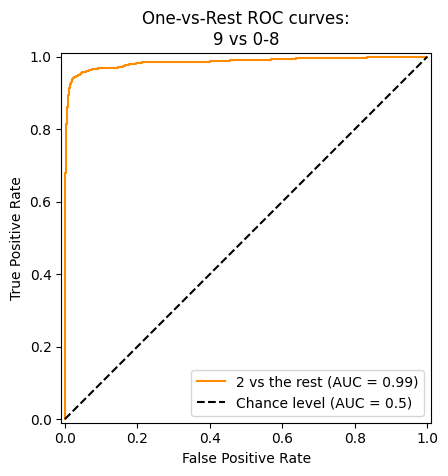

In [10]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

class_of_interest = "2"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_scores[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n9 vs 0-8",
)

Now, consider a scenario where our dataset is very small. How can we obtain a reliable estimate of the model's performance? We will employ cross-validation. The implementation of this technique is demonstrated in the following cell.

In [11]:
num_samples = 500
scores = cross_val_score(model, mnist.data[:num_samples], mnist.target[:num_samples], cv=5)
print(f"Cross-validation scores: ", scores)

Cross-validation scores:  [0.78 0.88 0.82 0.89 0.8 ]


## Questions

**Q2.** When utilizing 500 data samples, how do the outcomes differ between employing 2-fold cross-validation and 5-fold cross-validation?

**Q3.** As your dataset expands, do you typically augment the number of folds for internal validation, or is it more common to decrease them? What are the factors influencing this decision?

# Segmentation

We won't be training a segmentation model in this instance. However, let's consider an imaginary ground truth representing cancer cells on a histopathology slice. In addition to this ground truth, we have two predictions from different models attempting to segment the cancerous cells. Refer to the figure below.

Text(0.5, 1.0, 'Prediction 2')

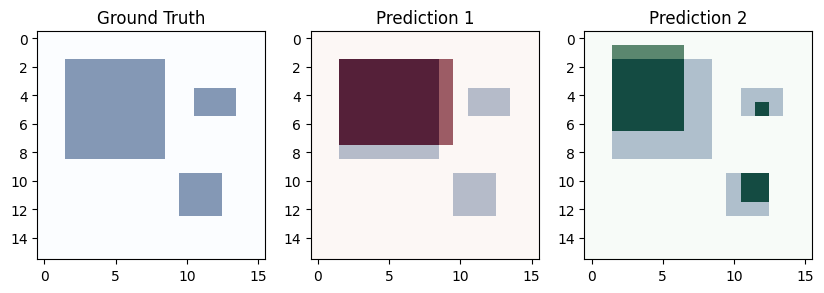

In [4]:
# Create the reference mask
mask1 = np.zeros((16, 16), dtype=int)
mask1[2:9, 2:9] = 1 
mask1[4:6, 11:14] = 1
mask1[10:13, 10:13] = 1

# first prediction
mask2 = np.zeros((16, 16), dtype=int)
mask2[2:8, 2:10] = 1  

# second prediction
mask3 = np.zeros((16, 16), dtype=int)
mask3[1:7, 2:7] = 1 
mask3[5:6, 12:13] = 1
mask3[10:12, 11:13] = 1

# Plot the masks
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.imshow(mask1, cmap='Blues', alpha=0.5)
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(mask2, cmap='Reds', alpha=0.9)
plt.imshow(mask1, cmap='Blues', alpha=0.3)
plt.title('Prediction 1')

plt.subplot(1, 3, 3)
plt.imshow(mask3, cmap='Greens', alpha=0.9)
plt.imshow(mask1, cmap='Blues', alpha=0.3)
plt.title('Prediction 2')

Try to implement the Dice score and see which model performs best!

In [18]:
 # to do: implement the dice score 
def dice_score(mask1, mask2):
    """
    Calculate the Dice score between two binary masks.

    Parameters:
        mask1 (ndarray): The first binary mask.
        mask2 (ndarray): The second binary mask.

    Returns:
        float: The Dice score between the two masks.
    """
    overlap = np.sum(np.multiply(mask1,mask2))
    total_area = np.sum(mask1)+np.sum(mask2)
    dice = 2*overlap/total_area 
    return dice
    pass


In [17]:
overlap = np.sum(np.multiply(mask1,mask2))
total_area = np.sum(mask1)+np.sum(mask2)
dice = 2*overlap/total_area 
dice

np.float64(0.75)

In [19]:
dice_score_mask1_mask2 = dice_score(mask1, mask2)
print("Dice score between Ground truth and Prediction 1:", round(dice_score_mask1_mask2, 2))

dice_score_mask1_mask3 = dice_score(mask1, mask3)
print("Dice score between Ground truth and Prediction 2:", round(dice_score_mask1_mask3, 2))

Dice score between Ground truth and Prediction 1: 0.75
Dice score between Ground truth and Prediction 2: 0.61


## Questions

**Q3.** Based on the Dice score calculation, which model demonstrates superior performance, and what factors contribute to this result?

**Q4.** Beyond the Dice score, what additional metrics should be considered to gain a comprehensive understanding of model performance?

**Q5.** Do you stick with your choice or do you maybe thing the other model is better?